# Q Sampler 

---

今回はこの[論文](https://proceedings.mlr.press/v201/agarwal23a/agarwal23a.pdf)に出てきたQ Samplerというアルゴリズムの説明をコードも書きながら解説していきます．

完璧に理解できていないので，間違っていることを書くかもしれません．

まず，アルゴリズムの流れは以下の流れになっています．

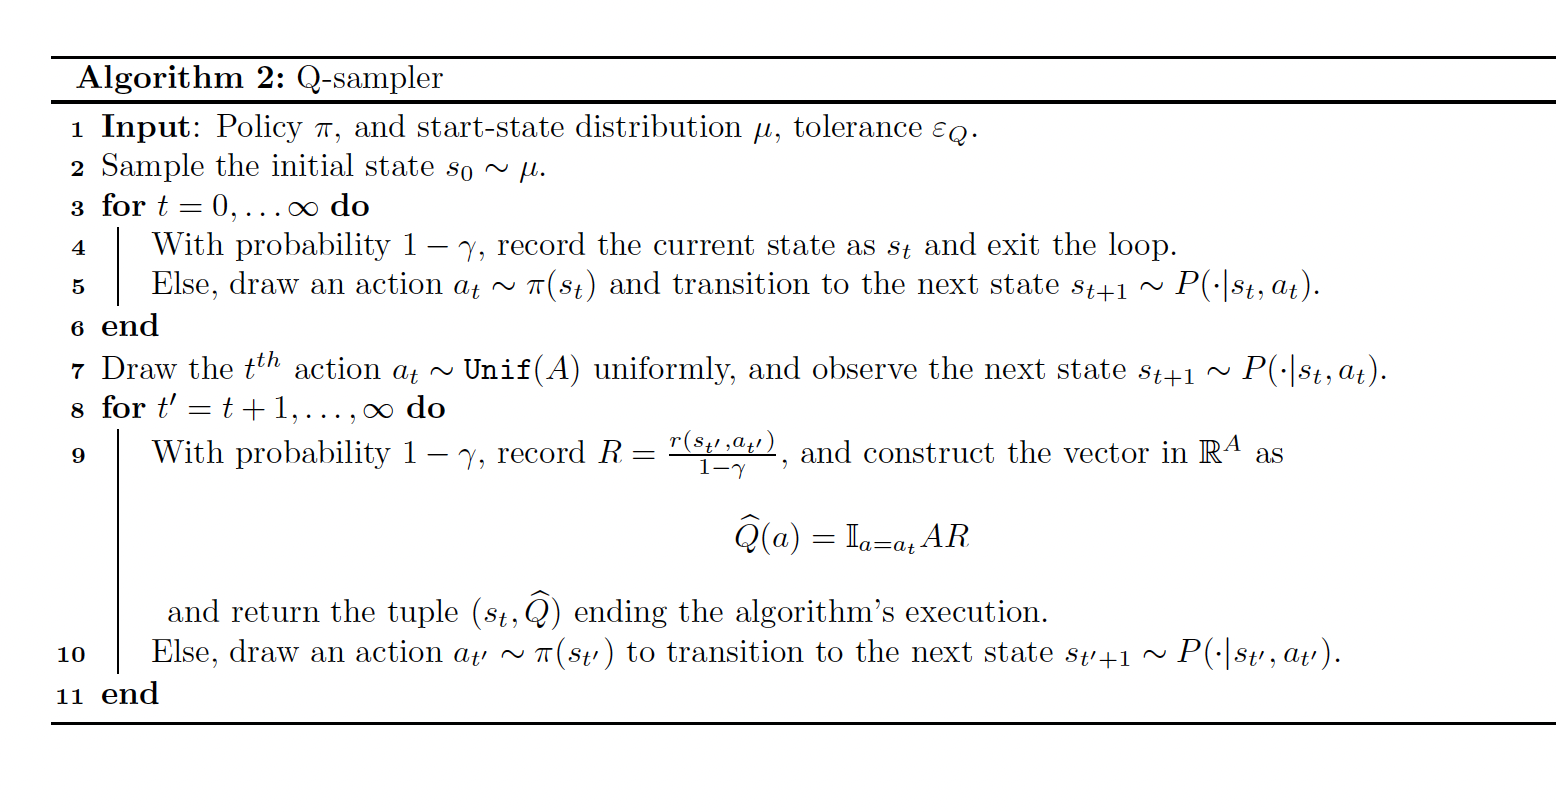

まず，Conservative Policy Iteration(CPI)では次のような流れで方策を更新しています．

$$
\pi_{t+1} = \alpha  \pi_{t} + (1-\alpha)  \hat\pi_{t}
$$

ここで，$\alpha$ は任意の正の定数です．

従来のCPIでは$\hat\pi_{t}$を現在の方策に対するグリーディーな方策でおいたのですが，上の論文では次のような方法で$\hat\pi_{t}$で求めるようにしています．

$$
\pi_t^{\prime}=\operatorname{argmin}\left\langle\nabla V^{\pi_t}, \pi\right\rangle
$$

$$
\left\langle\nabla V_\mu^\pi, \pi^{\prime}\right\rangle=\frac{1}{1-\gamma} \mathbb{E}_{s \sim d_\mu^\pi}\left[Q^\pi(s, \cdot)^{\top} \pi^{\prime}(s)\right]
$$

内積の性質から，大きければ大きいほど２つのベクトル間は似ているということがわかるので，上の式ではargminしていることから，できるだけ，今の勾配と離れているような方策を求めています，

私の認識ではこれは探索を促す性質(?)もあるのかと考えました．

ここにおけるCPIのサンプル効率の問題は$\nabla V^{\pi_t}$のvarianceを減らすことができるかです．この理由はサンプル複雑度に深く関わってくるからです．

---

その理由としては，variance reductionをするために上の論文では，STORMアルゴリズムというものを使います．$F(x)=\mathbb{E}[f(x, \xi) \mid x]$は確率的な関数とします．
$$
v_t \triangleq(1-\lambda) v_{t-1}+\lambda \nabla f\left(x_t, \xi_t\right)+(1-\lambda)\left(\nabla f\left(x_t, \xi_t\right)-\nabla f\left(x_{t-1}, \xi_t\right)\right)
$$

このような形で，$v_{t}$を更新していきます．

$\nabla f\left(x_t, \xi_t\right)-\nabla f\left(x_{t-1}, \xi_t\right)$の項の計算は現在の方策に依存しているの，難しいです．

その代わりに，$f$のヘッセ行列(2回微分した)を使うと次のように近似できます．

$$
\nabla f\left(x_t, \xi_t\right)-\nabla f\left(x_{t-1}, \xi_t\right) \sim \nabla^2 f\left((1-b) x_t+b x_{t-1}, \xi_t\right)\left(x_t-x_{t-1}\right)
$$

**???なんで一階微分がむずいのに，2回微分いいの？?**

この$F$は強化学習の問題に置き換えると次のようになります．

$$
F^\pi\left(s, a \mid \pi^{\prime}\right)=\mathbb{E}_{s^{\prime} \sim P(\cdot \mid s, a)} \mathbb{E}_{s^{\prime \prime} \sim d_{s^{\prime}}^\pi}\left[Q^\pi\left(s^{\prime \prime}, \cdot\right)^{\top} \pi^{\prime}\left(s^{\prime \prime}\right)\right]
$$

このようになります．

---

しかしながら，$Q^\pi$ は$\pi$と関連しているので，微分を考える時に複雑になり，難しいということで，Q Samplerでこの$Q^\pi$を置き換えることを考えます．

$s \sim d_\mu^\pi, \text { and } \mathbb{E}[\widehat{Q} \mid s, \pi]=Q^\pi(s, \cdot)$と置き換えることを考えると次のように書けます，

$$
\left\langle\nabla V_\mu^\pi, \pi^{\prime}\right\rangle=\frac{1}{1-\gamma} \mathbb{E}_{(s, \widehat{Q}) \sim \mathcal{A}}\left[\widehat{Q}^{\top} \pi^{\prime}(s)\right]
$$

---

早速コードを書いていきます．



In [3]:
import numpy as np
from typing import NamedTuple

S = 5 # number of states
A = 3 # number of actions
S_array =  np.arange(S)
A_array = np.arange(A)
gamma = 0.99 #割引率
rew = np.random.rand(S,A) * 10 #報酬

P = np.random.rand(S*A, S) #遷移確率
P = P / np.sum(P,axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_almost_equal(P.sum(axis=-1),1) #確率1になっているか確認

mu = np.random.rand(S) #初期状態分布
mu = mu / np.sum(mu)
np.testing.assert_almost_equal(mu.sum(),1) #確率1になっているか確認
# MDPの定義

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    rew : np.array
    P : np.array

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)

mdp = MDP(S_array,A_array,gamma,rew,P)
print(mdp.rew.shape)
print(mdp.P.shape)
# 任意の方策を作成
pi = np.random.rand(S,A)
pi = pi / np.sum(pi,axis=-1,keepdims=True)
np.testing.assert_almost_equal(pi.sum(axis=-1),1) 

(5, 3)
(5, 3, 5)
